<a href="https://colab.research.google.com/github/anakinZhe/FRCodeExercise/blob/main/FetchRewards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import data from provided JSON files
ssers.json file is stored in a dataframe called `users`

brands.json file is stored in a dataframe called `brands`

receipts.json file is stored in dataframes `receipts` and `itemList`


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# import data for users
with open("/content/users-2.json", "r") as f:
    users = [json.loads(x) for x in f.read().splitlines()]
with open("/content/users-2.json", "w") as f:
    json.dump(users, f)
while len(users) == 1:
  users = users[0]
for i in users:
  i['_id'] = i['_id']['$oid']
  i['createdDate'] = int(i['createdDate']['$date'])
  try:
    i['lastLogin'] = int(i['lastLogin']['$date'])
  except KeyError:
    continue
item = []
for i in range(len(users)):
  item.append(i)
users = pd.DataFrame.from_dict(dict(zip(item,users)), orient = 'index') 

# import data for brands
with open("/content/brands-2.json", "r") as f:
    brands = [json.loads(x) for x in f.read().splitlines()]
with open("/content/brands-2.json", "w") as f:
    json.dump(brands, f)
while len(brands) == 1:
  brands = brands[0]
for i in brands:
  i['_id'] = i['_id']['$oid']
  i['cpg_id'] = i['cpg']['$id']['$oid']
  i['cpg_ref'] = i['cpg']['$ref']
  i.pop('cpg')
item = []
for i in range(len(brands)):
  item.append(i)
brands = pd.DataFrame.from_dict(dict(zip(item,brands)), orient = 'index') 

# import data for receipts
with open("/content/receipts-2.json", "r") as f:
    receipt = [json.loads(x) for x in f.read().splitlines()]
with open("/content/receipts-2.json", "w") as f:
    json.dump(receipt, f)
while len(receipt) == 1:
  receipt = receipt[0]
itemList = []
for i in receipt:
  i['_id'] = i['_id']['$oid']
  try:
    itemList += i['rewardsReceiptItemList']
    i.pop('rewardsReceiptItemList')
  except KeyError:
    continue
item = []
for i in range(len(receipt)):
  item.append(i)
receipts = pd.DataFrame.from_dict(dict(zip(item,receipt)), orient = 'index') 
# item list on receipts table
item = []
for i in range(len(itemList)):
  item.append(i)
itemList = pd.DataFrame.from_dict(dict(zip(item,itemList)), orient = 'index') 

## `users` table

In [2]:
users.head()

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,1609687444800,1.609688e+12,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,1609687444800,1.609688e+12,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,1609687444800,1.609688e+12,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,1609687530554,1.609688e+12,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,1609687444800,1.609688e+12,consumer,Email,WI


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495 entries, 0 to 494
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _id           495 non-null    object 
 1   active        495 non-null    bool   
 2   createdDate   495 non-null    int64  
 3   lastLogin     433 non-null    float64
 4   role          495 non-null    object 
 5   signUpSource  447 non-null    object 
 6   state         439 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 27.6+ KB


Apparently, the `users` table have lots of duplicates. Here, we delete the duplicates first, and then covert the Unix timestamps to a readable format. 

In [4]:
users.drop_duplicates(subset ="_id", keep = False, inplace = True)
users['createdDate'] = pd.to_datetime(users['createdDate']//1000,unit='s')
users['lastLogin'] = pd.to_datetime(users['lastLogin']//1000,unit='s')
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 6 to 462
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   _id           142 non-null    object        
 1   active        142 non-null    bool          
 2   createdDate   142 non-null    datetime64[ns]
 3   lastLogin     112 non-null    datetime64[ns]
 4   role          142 non-null    object        
 5   signUpSource  140 non-null    object        
 6   state         142 non-null    object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 7.9+ KB


The new table looks good to me. Only the `lastLogin` column has some missing values.

Let's have a look at each column. 

In [5]:
# non-numeric columns
print('\n>>active:\n')
print(users.active.value_counts())
print('\n>>role:\n')
print(users.role.value_counts())
print('\n>>state:\n')
print(users.state.value_counts())
print('\n>>sign up source:\n')
print(users.signUpSource.value_counts())


>>active:

True     141
False      1
Name: active, dtype: int64

>>role:

consumer       139
fetch-staff      3
Name: role, dtype: int64

>>state:

WI    134
IL      3
AL      2
KY      1
CO      1
SC      1
Name: state, dtype: int64

>>sign up source:

Email     138
Google      2
Name: signUpSource, dtype: int64


Text(0.5, 1.0, 'Users that Created after 2021')

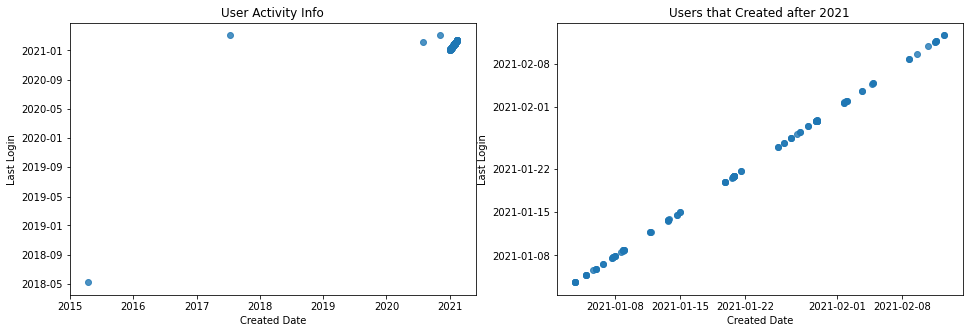

In [6]:
# numeric columns

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
# all records
ax1.scatter(users['createdDate'], users['lastLogin'], alpha=0.8)
ax1.set_xlabel('Created Date')
ax1.set_ylabel('Last Login')
ax1.set_title('User Activity Info')
# selected records
users1 = users[users.createdDate >= '2021-01-01']
ax2.scatter(users1['createdDate'], users1['lastLogin'], alpha=0.8)
ax2.set_xlabel('Created Date')
ax2.set_ylabel('Last Login')
ax2.set_title('Users that Created after 2021')

It shows that there are some outliers in the table. Let's pull them out.

In [7]:
users[(users.active == False) | (users.role == 'fetch-staff') | (users.state != 'WI') | (users.signUpSource != 'Email') | (users.createdDate < '2021-01-01')]

,_id,active,createdDate,lastLogin,role,signUpSource,state
97,5ff616a68f142f11dd189163,True,2021-01-06 19:59:34,NaT,consumer,Email,KY
170,5e27526d0bdb6a138c32b556,True,2020-01-21 19:35:09,NaT,consumer,Google,WI
195,60023de5fb296c121a81b955,True,2021-01-16 01:14:13,NaT,consumer,Email,CO
223,6006f786fb296c7f688530f8,True,2021-01-19 15:15:18,NaT,consumer,Email,AL
240,6008622ebe5fc9247bab4eb9,False,2021-01-20 17:02:38,2021-01-20 17:02:38,consumer,Email,WI
247,6008f02fb6310511daa4f314,True,2021-01-21 03:08:31,NaT,consumer,Email,IL
258,6008e9cdb6310511daa4f2e4,True,2021-01-21 02:41:17,NaT,consumer,Email,IL
379,60183e6c9a1b091205b61b49,True,2021-02-01 17:46:20,NaT,consumer,Email,SC
388,55308179e4b0eabd8f99caa2,True,2015-04-17 03:43:53,2018-05-07 17:23:40,consumer,NaN,WI
408,5f2068904928021530f8fc34,True,2020-07-28 18:04:00,2021-02-04 15:30:05,fetch-staff,Email,WI


## `brands` table

In [8]:
brands.head()

,_id,barcode,category,categoryCode,name,topBrand,cpg_id,cpg_ref,brandCode
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,test brand @1612366101024,False,601ac114be37ce2ead437550,Cogs,NaN
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,Starbucks,False,5332f5fbe4b03c9a25efd0ba,Cogs,STARBUCKS
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,test brand @1612366146176,False,601ac142be37ce2ead437559,Cogs,TEST BRANDCODE @1612366146176
3,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,test brand @1612366146051,False,601ac142be37ce2ead437559,Cogs,TEST BRANDCODE @1612366146051
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,test brand @1612366146827,False,5332fa12e4b03c9a25efd1e7,Cogs,TEST BRANDCODE @1612366146827


In [9]:
brands.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1167 entries, 0 to 1166
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           1167 non-null   object
 1   barcode       1167 non-null   object
 2   category      1012 non-null   object
 3   categoryCode  517 non-null    object
 4   name          1167 non-null   object
 5   topBrand      555 non-null    object
 6   cpg_id        1167 non-null   object
 7   cpg_ref       1167 non-null   object
 8   brandCode     933 non-null    object
dtypes: object(9)
memory usage: 91.2+ KB


It shows that a lot of values are missing in `categoryCode`, `topBrand`, and `brandCode`. Based on the information in this exercise, `brandCode` should be an important field for joining tables together, the absence of which can be a big problem.

Let's take a look at each column in detial. 

In [10]:
print('\n>>name:\n')
print(brands.name.value_counts().head(15))
print('\n>>brand code:\n')
print(brands.brandCode.value_counts())
print('\n>>barcode:\n')
print(brands.barcode.value_counts().head(10))
print('\n>>category:\n')
print(brands.category.value_counts())
print('\n>>category code:\n')
print(brands.categoryCode.value_counts())
print('\n>>top brand or not:\n')
print(brands.topBrand.value_counts())
print('\n>>cpg id:\n')
print(brands.cpg_id.value_counts().head(10))
print('\n>>cpg ref:\n')
print(brands.cpg_ref.value_counts())


>>name:

Huggies                             2
V8 Hydrate                          2
Pull-Ups                            2
Dippin Dots® Cereal                 2
Diabetic Living Magazine            2
Baken-Ets                           2
Health Magazine                     2
I CAN'T BELIEVE IT'S NOT BUTTER!    2
Caleb's Kola                        2
ONE A DAY® WOMENS                   2
Sierra Mist                         2
test brand @1612366101024           1
test brand @1599159969725           1
Wyler's                             1
test brand @1598881723241           1
Name: name, dtype: int64

>>brand code:

                                 35
GOODNITES                         2
HUGGIES                           2
ROYAL DANSK                       1
SOL                               1
                                 ..
TEST BRANDCODE @1599159969028     1
TEST BRANDCODE @1597350074404     1
SEDAL                             1
RED ROCK DELI                     1
TEST BRANDCODE @161

It shows some duplicates in `name`, `barcode`, and `brandCode`.

The `category` and `categoryCode` don't match, and it should be solved. 

There are more missing values in `brandCode` than what are shown above. 

## `receipts` table and `itemList` table

In [11]:
receipts.head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedu...",{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687536000},{'$date': 1609687531000},500.0,{'$date': 1609632000000},5.0,FINISHED,26.00,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,FINISHED,11.00,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,{'$date': 1609687537000},{'$date': 1609687537000},NaN,{'$date': 1609687542000},NaN,5,{'$date': 1609632000000},1.0,REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687539000},{'$date': 1609687534000},5.0,{'$date': 1609632000000},4.0,FINISHED,28.00,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,{'$date': 1609687506000},{'$date': 1609687506000},{'$date': 1609687511000},{'$date': 1609687511000},{'$date': 1609687506000},5.0,{'$date': 1609601106000},2.0,FINISHED,1.00,5ff1e194b6a9d73a3a9f1052


In [12]:
receipts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1119 entries, 0 to 1118
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      1119 non-null   object 
 1   bonusPointsEarned        544 non-null    float64
 2   bonusPointsEarnedReason  544 non-null    object 
 3   createDate               1119 non-null   object 
 4   dateScanned              1119 non-null   object 
 5   finishedDate             568 non-null    object 
 6   modifyDate               1119 non-null   object 
 7   pointsAwardedDate        537 non-null    object 
 8   pointsEarned             609 non-null    object 
 9   purchaseDate             671 non-null    object 
 10  purchasedItemCount       635 non-null    float64
 11  rewardsReceiptStatus     1119 non-null   object 
 12  totalSpent               684 non-null    object 
 13  userId                   1119 non-null   object 
dtypes: float64(2), object(12

In [13]:
receipts[receipts.totalSpent.isnull()]

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId
71,5ff475820a7214ada10005cf,NaN,NaN,{'$date': 1609856386000},{'$date': 1609856386000},NaN,{'$date': 1609856386000},NaN,NaN,NaN,NaN,SUBMITTED,NaN,5a43c08fe4b014fd6b6a0612
93,5ff5ecb90a7214ada10005f9,NaN,NaN,{'$date': 1609952440000},{'$date': 1609952440000},NaN,{'$date': 1609952440000},NaN,NaN,NaN,NaN,SUBMITTED,NaN,5a43c08fe4b014fd6b6a0612
149,5ff726860a720f05230005ec,NaN,NaN,{'$date': 1610032774000},{'$date': 1610032774000},NaN,{'$date': 1610032774000},NaN,NaN,NaN,NaN,SUBMITTED,NaN,5ff7264e8f142f11dd189504
212,5ffce8570a7214ad4e003e6f,NaN,NaN,{'$date': 1610410071000},{'$date': 1610410071000},NaN,{'$date': 1610410071000},NaN,NaN,NaN,NaN,SUBMITTED,NaN,59c124bae4b0299e55b0f330
216,5ffce8250a7214ad4e0034de,NaN,NaN,{'$date': 1610410020000},{'$date': 1610410020000},NaN,{'$date': 1610410020000},NaN,NaN,NaN,NaN,SUBMITTED,NaN,59c124bae4b0299e55b0f330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,603c6adf0a720fde1000039a,NaN,NaN,{'$date': 1614572255736},{'$date': 1614572255736},NaN,{'$date': 1614572255736},NaN,NaN,NaN,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33
1111,603c9e6e0a720fde100003c7,NaN,NaN,{'$date': 1614585454307},{'$date': 1614585454307},NaN,{'$date': 1614585454307},NaN,NaN,NaN,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33
1115,603d0b710a720fde1000042a,NaN,NaN,{'$date': 1614613361873},{'$date': 1614613361873},NaN,{'$date': 1614613361873},NaN,NaN,NaN,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33
1116,603cf5290a720fde10000413,NaN,NaN,{'$date': 1614607657664},{'$date': 1614607657664},NaN,{'$date': 1614607657664},NaN,NaN,NaN,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33


It seems that a lot of records don't have enough information like others and are only used to store information like `rewardsReceiptStatus`. We will delete those records for now and check what others records look like. 

In [14]:
receipts_v = receipts[receipts.totalSpent.notnull()]
receipts_v['totalSpent'] = pd.to_numeric(receipts_v['totalSpent'])
receipts_v['pointsEarned'] = pd.to_numeric(receipts_v['pointsEarned'])
receipts_v.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 0 to 1117
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      684 non-null    object 
 1   bonusPointsEarned        544 non-null    float64
 2   bonusPointsEarnedReason  544 non-null    object 
 3   createDate               684 non-null    object 
 4   dateScanned              684 non-null    object 
 5   finishedDate             567 non-null    object 
 6   modifyDate               684 non-null    object 
 7   pointsAwardedDate        537 non-null    object 
 8   pointsEarned             609 non-null    float64
 9   purchaseDate             671 non-null    object 
 10  purchasedItemCount       635 non-null    float64
 11  rewardsReceiptStatus     684 non-null    object 
 12  totalSpent               684 non-null    float64
 13  userId                   684 non-null    object 
dtypes: float64(4), object(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
receipts_v

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedu...",{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687536000},{'$date': 1609687531000},500.0,{'$date': 1609632000000},5.0,FINISHED,26.00,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,FINISHED,11.00,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,{'$date': 1609687537000},{'$date': 1609687537000},NaN,{'$date': 1609687542000},NaN,5.0,{'$date': 1609632000000},1.0,REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687539000},{'$date': 1609687534000},5.0,{'$date': 1609632000000},4.0,FINISHED,28.00,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,{'$date': 1609687506000},{'$date': 1609687506000},{'$date': 1609687511000},{'$date': 1609687511000},{'$date': 1609687506000},5.0,{'$date': 1609601106000},2.0,FINISHED,1.00,5ff1e194b6a9d73a3a9f1052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,603c7c6c0a7217c72c0003b3,25.0,COMPLETE_NONPARTNER_RECEIPT,{'$date': 1614576748000},{'$date': 1614576748000},NaN,{'$date': 1614576749000},NaN,25.0,{'$date': 1597622400000},2.0,REJECTED,34.96,5fc961c3b8cfca11a077dd33
1112,603c3d240a720fde10000373,25.0,COMPLETE_NONPARTNER_RECEIPT,{'$date': 1614560548000},{'$date': 1614560548000},NaN,{'$date': 1614560549000},NaN,25.0,{'$date': 1597622400000},2.0,REJECTED,34.96,5fc961c3b8cfca11a077dd33
1113,603cc2bc0a720fde100003e9,25.0,COMPLETE_NONPARTNER_RECEIPT,{'$date': 1614594748000},{'$date': 1614594748000},NaN,{'$date': 1614594749000},NaN,25.0,{'$date': 1597622400000},2.0,REJECTED,34.96,5fc961c3b8cfca11a077dd33
1114,603cc0630a720fde100003e6,25.0,COMPLETE_NONPARTNER_RECEIPT,{'$date': 1614594147000},{'$date': 1614594147000},NaN,{'$date': 1614594148000},NaN,25.0,{'$date': 1597622400000},2.0,REJECTED,34.96,5fc961c3b8cfca11a077dd33


In [16]:
print('\n>>status:\n')
print(receipts_v.rewardsReceiptStatus.value_counts())
print('\n>>bonbus points earned reason:\n')
print(receipts_v.bonusPointsEarnedReason.value_counts())


>>status:

FINISHED    518
REJECTED     71
PENDING      49
FLAGGED      46
Name: rewardsReceiptStatus, dtype: int64

>>bonbus points earned reason:

All-receipts receipt bonus                                                             183
Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)    119
COMPLETE_NONPARTNER_RECEIPT                                                             71
COMPLETE_PARTNER_RECEIPT                                                                39
Receipt number 3 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)     31
Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)     30
Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)     27
Receipt number 4 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)     26
Receipt number 6 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)     18
Name: bonusPointsEarnedReason, 

Text(0.5, 1.0, 'Bonus Points Earned')

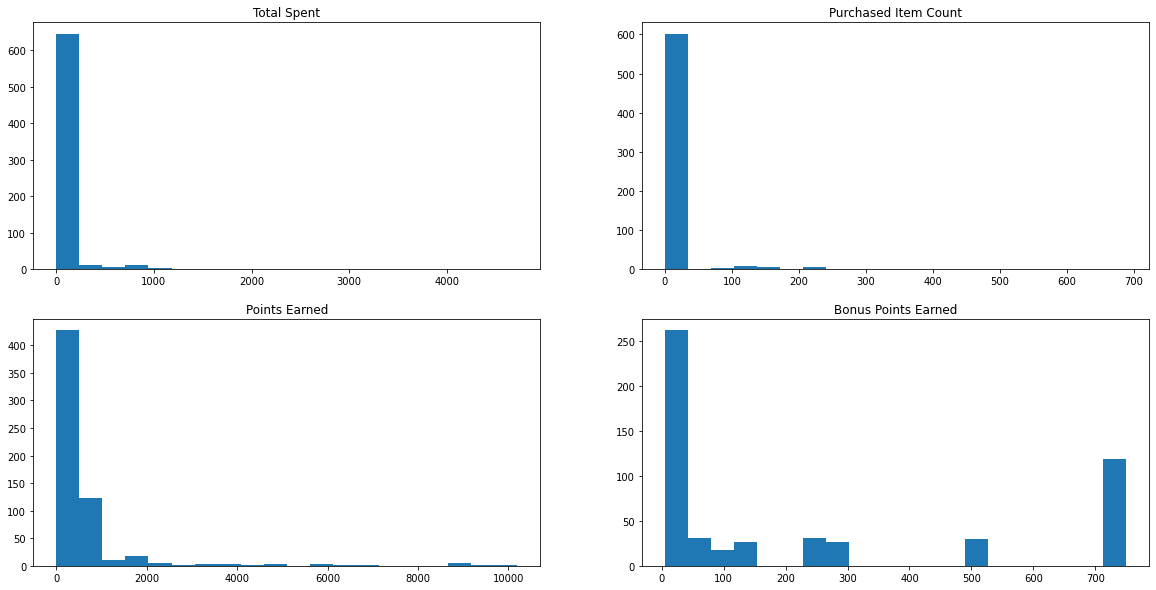

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
n_bins = 20
axs[0,0].hist(receipts_v['totalSpent'], n_bins)
axs[0,0].set_title('Total Spent')
axs[0,1].hist(receipts_v['purchasedItemCount'], n_bins)
axs[0,1].set_title('Purchased Item Count')
axs[1,0].hist(receipts_v['pointsEarned'], n_bins)
axs[1,0].set_title('Points Earned')
axs[1,1].hist(receipts_v['bonusPointsEarned'], n_bins)
axs[1,1].set_title('Bonus Points Earned')

In [18]:
itemList.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6941 entries, 0 to 6769
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   barcode                             3090 non-null   object 
 1   description                         6560 non-null   object 
 2   finalPrice                          6767 non-null   object 
 3   itemPrice                           6767 non-null   object 
 4   needsFetchReview                    813 non-null    object 
 5   partnerItemId                       6941 non-null   object 
 6   preventTargetGapPoints              358 non-null    object 
 7   quantityPurchased                   6767 non-null   float64
 8   userFlaggedBarcode                  337 non-null    object 
 9   userFlaggedNewItem                  323 non-null    object 
 10  userFlaggedPrice                    299 non-null    object 
 11  userFlaggedQuantity                 299 non

A large portion of fields in this table has lots of missing values. This is acceptable as not every record needs to have all the information. However, missing values in some important fields that we have mentioned above like `barcode` and `brandCode` are definitly not good. 

Also, it's easy to notice that only the `partnerItemId` field doesn't have missing values, meaning there might not be enough information to identify records.